# 📊 View as a histogram

In [ ]:
#| default_exp repr_plt

In [ ]:
# |hide
from nbdev.showdoc import *
from fastcore.test import test_eq, is_close

In [ ]:
# |export
# |hide

import math
from typing import Union
from matplotlib import pyplot as plt
from IPython.core.pylabtools import print_figure
import torch

from lovely_tensors.repr_str import to_str, pretty_str
from lovely_numpy import plot as np_plot

In [ ]:
# |hide
# |exporti
def normal_pdf( x: torch.Tensor,
                mean: Union[torch.Tensor, float] =0.,
                std: Union[torch.Tensor, float] =1.):
    r"""Probability Distribution Function of Normal Distribution:
        $$f(x, \mu, \sigma)
        = \dfrac{1}
            {\sigma \sqrt{2\pi} }
        e^{-\frac{1}{2} \left(\frac{x-\mu}{\sigma}\right)^{2}}
        = \dfrac{e^{- \frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}}}
            {\sigma \sqrt{2\pi}}$$"""

    dev = x.device
    e = torch.tensor(math.e).to(dev)
    pi = torch.tensor(math.pi).to(dev)

    mean = torch.tensor(mean).to(dev) if not isinstance(mean, torch.Tensor) else mean
    std = torch.tensor(std).to(dev) if not isinstance(std, torch.Tensor) else std

    return (e
                .pow( -0.5 * ((x - mean)/std).pow(2) )
                .div((std * (pi * 2).sqrt()))
            )

In [ ]:
# |hide
# |eval: false

# import scipy
# x = torch.arange(-4, 4, 0.01)
# y1 = torch.tensor(scipy.stats.norm.pdf(x, 2, 3))
# y2 = normal_pdf(x, 2, 3)

# test_eq(is_close(y1, y2), True)

In [ ]:
# |exporti

# This is here for the monkey-patched tensor use case.
# Gives the ability to call both .plt and .plt(ax=ax).  

class PlotProxy(): 
    """Flexible `PIL.Image.Image` wrapper"""
    @torch.no_grad()
    def __init__(self, t:torch.Tensor, center="zero", max_s=10000, plt0=True, fmt="png"):
        self.t = t
        self.center = center
        self.fmt = fmt
        self.max_s = max_s
        self.plt0 = plt0
        assert fmt in ["png", "svg"]
        assert center in ["zero", "mean", "range"]

    def __call__(self, center=None, max_s=None, plt0=None, fmt=None, ax=None):
        t = self.t
        center = center or self.center
        fmt = fmt or self.fmt
        if max_s is None: max_s = self.max_s
        if plt0 is None: plt0 = self.plt0
        if ax:
            summary = to_str(t, color=False)
            np_plot(t.detach().cpu().numpy(), center=center, max_s=max_s, plt0=plt0, ax=ax, summary=summary)
            return ax

        return PlotProxy(self.t, center=center, max_s=max_s, plt0=plt0, fmt=fmt)

    # Do an explicit print_figure instead of relying on IPythons repr formatter
    # for pyplot.Figure. Mainly for speed.
    #
    # IPython will attempt to render the figure in a bunch of formats, and then
    # pick one to show. This takes a noticeable amount of time. Render just
    # one format instead.
    def _repr_svg_(self):
        if self.fmt == "svg":
            summary = to_str(self.t, color=False)
            t = self.t.detach().cpu().numpy()
            return print_figure(np_plot(t, center=self.center, max_s=self.max_s, plt0=self.plt0, summary=summary), fmt="svg")

    def _repr_png_(self):
        if self.fmt == "png":
            summary = to_str(self.t, color=False)
            t = self.t.detach().cpu().numpy()
            return print_figure(np_plot(t, center=self.center, max_s=self.max_s, plt0=self.plt0, summary=summary), fmt="png")


In [ ]:
# |export
def plot(t: torch.Tensor, # Tensor to explore
    center="zero",        # Center plot on  `zero`, `mean`, or `range`
    max_s=10000,          # Draw up to this many samples. =0 to draw all
    plt0=True,            # Take zero values into account
    fmt="png",            # Render figure in this format (`png`, `svg`)
    ax=None):             # Optionally supply your own matplotlib axes.
    return PlotProxy(t=t, fmt=fmt)(center=center, max_s=max_s, plt0=plt0, ax=ax)

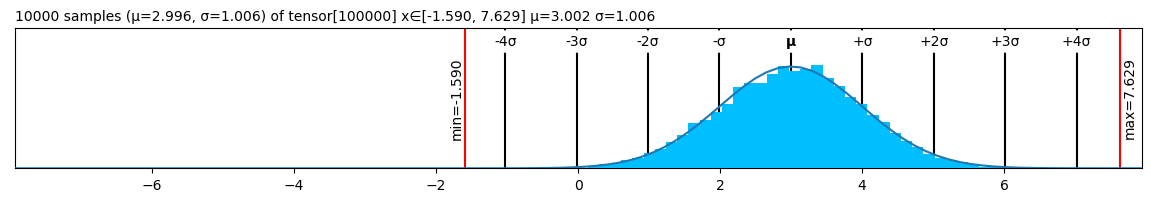

In [ ]:
torch.manual_seed(42)
t = torch.randn(100000)+3
plot(t)

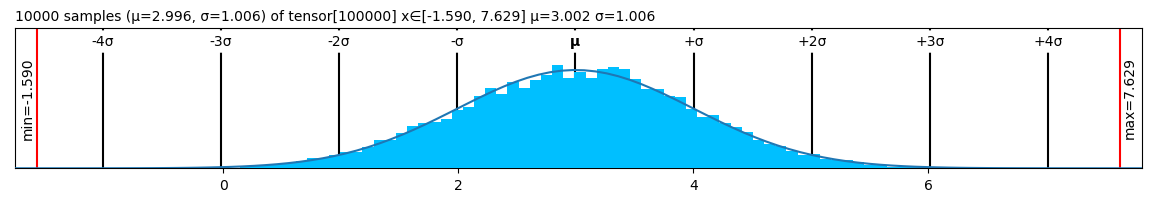

In [ ]:
plot(t, center="range")

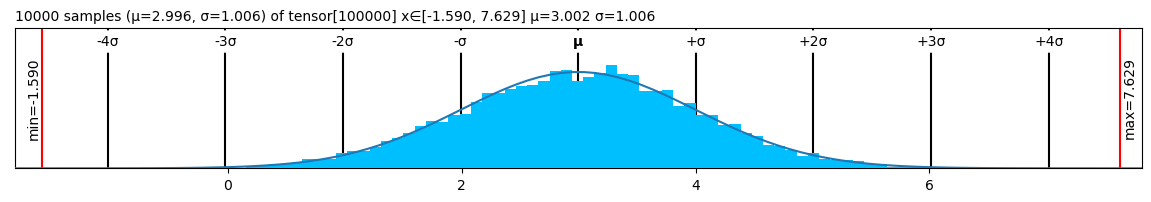

In [ ]:
plot(t, center="mean")

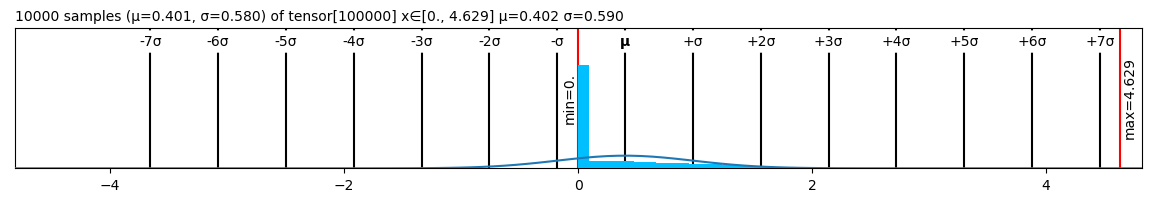

In [ ]:
plot(torch.nn.functional.relu(t-3))

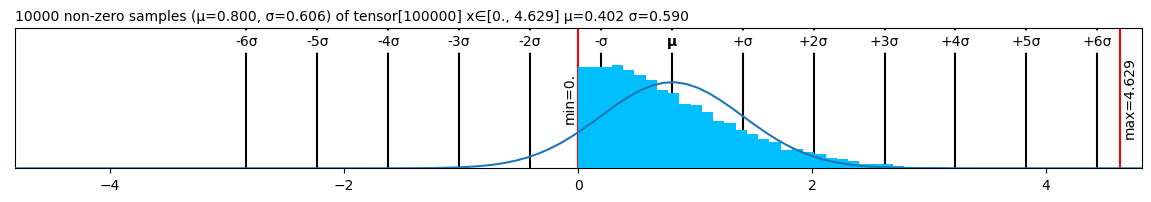

In [ ]:
plot(torch.nn.functional.relu(t-3), plt0=False)

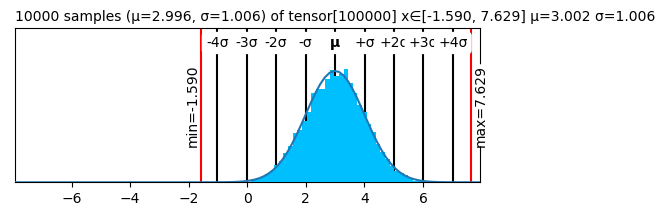

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2))
_ = plot(t, ax=ax)

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()